<a href="https://colab.research.google.com/github/ignacioaranguren1/bd_2/blob/main/bd_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import keras_tuner
import datetime as dt

from tqdm import tqdm
from datetime import datetime
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.layers import BatchNormalization

In [2]:
%matplotlib inline

datapath = r'/Users/ignacioaranguren/bd_2'
os.chdir(datapath)

## 1.In the data used by Gu, Kelly and Xiu (RFS 2019 – provided in class), use a similar procedure to theirs to predict stock returns with neural networks. Start by finding a suitable baseline configuration, and use a validation procedure to pick optimal hyperparameters for three neural network models: One with 2 hidden layers, one with 3 hidden layers, and one with 4 hidden layers.

In [3]:
# Data loading
data = pd.read_pickle('data/returns_chars_panel.pkl')
macro = pd.read_pickle('data/macro_timeseries.pkl')

In [4]:
# Train validation split
def train_validation_test_split(data, train_end_index, validation_end_index):
    tmp = data.reset_index()
    train = tmp.iloc[:train_end_index].set_index(['date','permno'],drop=True)
    validation = tmp[train_end_index:validation_end_index].set_index(['date','permno'],drop=True)
    test = tmp[validation_end_index:].set_index(['date','permno'],drop=True)
    return train, validation, test

In [5]:
# Merge data and macro dataframe on date
data_merged = pd.merge(data,macro,on=['date'])
# Set muti-indexing on date a permno
data_merged.set_index(['date','permno'],drop=True,inplace=True)
# Sort values by date
data_merged = data_merged.sort_values(['date'])

In [28]:
# Define test, validation and train splits
train_ratio = 0.65
validation_ratio = 0.15
train_index = int(len(data_merged) * train_ratio)
validation_index = int(len(data_merged) * (train_ratio + validation_ratio))
# Get predictors
X = data_merged.iloc[:,3:].copy()
# Get reponse variable
y = data_merged['excess_ret'].copy()

In [7]:
# Create train, validation and test sets for X and y
X_train,X_validation,X_test = train_validation_test_split(X,train_index,validation_index)
y_train,y_validation,y_test = train_validation_test_split(y,train_index,validation_index)

In [12]:
X_train

mvel1      beta    betasq     chmom    dolvol   idiovol  \
date       permno                                                               
1957-03-01 10006   0.315043  0.200000  0.200000  0.800774  0.724596 -0.361165   
           21813  -0.123936 -0.054369 -0.054369  0.895551  0.407407  0.473786   
           21821   0.776727 -0.363107 -0.363107  0.388781  0.641026 -0.504854   
           21856   0.820246  0.066019  0.066019 -0.794971  0.646724 -0.415534   
           21864  -0.214759  0.654369  0.654369  0.713733 -0.312441  0.679612   
...                     ...       ...       ...       ...       ...       ...   
1999-12-01 81850  -0.372404  0.507135  0.506871 -0.241730 -0.562492  0.530127   
           81728  -0.753402 -0.762156 -0.767442 -0.619693 -0.234544  0.976744   
           81916  -0.066126 -0.170983 -0.171247  0.448033 -0.575367 -0.616543   
           81727  -0.925519  0.712209  0.712209 -0.273509 -0.987611  0.471195   
           81725  -0.181428  0.470666  0.470402 -0.674134  0.118912  0.838795   

                     indmom     mom1m     mom6m    mom12m  ...      ep_y  \
date       permno                                          ...             
1957-03-01 10006  -0.021739  0.468691  0.604207 -0.009671  ... -2.542474   
           21813  -0.021739 -0.675522 -0.629063 -0.988395  ... -2.542474   
           21821  -0.021739  0.865275  0.472275  0.466151  ... -2.542474   
           21856  -0.021739 -0.495256 -0.586998  0.266925  ... -2.542474   
           21864  -0.021739 -0.609108 -0.086042 -0.800774  ... -2.542474   
...                     ...       ...       ...       ...  ...       ...   
1999-12-01 81850   0.686396  0.946734 -0.620345  0.262047  ... -3.391104   
           81728  -0.461814 -0.837551 -0.499000 -0.320135  ... -3.391104   
           81916  -0.225060 -0.439383  0.206698 -0.403751  ... -3.391104   
           81727   0.783413  0.788985  0.387153  0.751237  ... -3.391104   
           81725   0.686396  0.734153 -0.289178  0.589476  ... -3.391104   

                        b/m  crsp_spvw      svar     tbl     tms     dfy  \
date       permno                                                          
1957-03-01 10006   0.584994  -0.024919  0.001056  0.0310  0.0018  0.0080   
           21813   0.584994  -0.024919  0.001056  0.0310  0.0018  0.0080   
           21821   0.584994  -0.024919  0.001056  0.0310  0.0018  0.0080   
           21856   0.584994  -0.024919  0.001056  0.0310  0.0018  0.0080   
           21864   0.584994  -0.024919  0.001056  0.0310  0.0018  0.0080   
...                     ...        ...       ...     ...     ...     ...   
1999-12-01 81850   0.155546   0.020822  0.001354  0.0507  0.0155  0.0079   
           81728   0.155546   0.020822  0.001354  0.0507  0.0155  0.0079   
           81916   0.155546   0.020822  0.001354  0.0507  0.0155  0.0079   
           81727   0.155546   0.020822  0.001354  0.0507  0.0155  0.0079   
           81725   0.155546   0.020822  0.001354  0.0507  0.0155  0.0079   

                      dfr      ntis      infl  
date       permno                              
1957-03-01 10006   0.0068  0.030173  0.003623  
           21813   0.0068  0.030173  0.003623  
           21821   0.0068  0.030173  0.003623  
           21856   0.0068  0.030173  0.003623  
           21864   0.0068  0.030173  0.003623  
...                   ...       ...       ...  
1999-12-01 81850   0.0037  0.018280  0.000595  
           81728   0.0037  0.018280  0.000595  
           81916   0.0037  0.018280  0.000595  
           81727   0.0037  0.018280  0.000595  
           81725   0.0037  0.018280  0.000595  

[2430641 rows x 105 columns]

In [13]:
X_validation

mvel1      beta    betasq     chmom    dolvol   idiovol  \
date       permno                                                               
1999-12-01 81669   0.464789 -0.285148 -0.285677  0.200573  0.407992 -0.455867   
           81666  -0.156839 -0.337474 -0.338002 -0.063819 -0.506863 -0.039641   
           81665   0.339938  0.663055  0.662791  0.210992  0.104336  0.337209   
           81661   0.699451  0.194239  0.193975 -0.385778  0.660634 -0.556818   
           81660   0.600859 -0.171512 -0.171776 -0.570201  0.514636 -0.719609   
...                     ...       ...       ...       ...       ...       ...   
2006-06-01 90944  -0.326892  0.000000  0.000000  0.000000 -0.373798  0.000000   
           90943   0.050394  0.000000  0.000000  0.000000 -0.170974  0.000000   
           90942  -0.940835  0.000000  0.000000  0.000000 -0.981070  0.000000   
           90952   0.571875  0.000000  0.000000  0.000000  0.262019  0.000000   
           90966   0.188643  0.000000  0.000000  0.000000  0.209435  0.000000   

                     indmom     mom1m     mom6m    mom12m  ...      ep_y  \
date       permno                                          ...             
1999-12-01 81669   0.798449  0.357677  0.139715  0.165929  ... -3.391104   
           81666  -0.841050 -0.320921 -0.419520 -0.541808  ... -3.391104   
           81665  -0.871718  0.580863 -0.797551 -0.873405  ... -3.391104   
           81661  -0.140931 -0.552543 -0.343914 -0.262568  ... -3.391104   
           81660  -0.185680  0.359364 -0.588353 -0.258401  ... -3.391104   
...                     ...       ...       ...       ...  ...       ...   
2006-06-01 90944   0.228631  0.510106  0.242938  0.000000  ... -2.844356   
           90943  -0.523264  0.763737 -0.315926  0.000000  ... -2.844356   
           90942   0.228631  0.682587 -0.951138  0.000000  ... -2.844356   
           90952   0.228631  0.187902  0.617652  0.000000  ... -2.844356   
           90966   0.228631  0.530469  0.912353  0.000000  ... -2.844356   

                        b/m  crsp_spvw      svar     tbl     tms     dfy  \
date       permno                                                          
1999-12-01 81669   0.155546   0.020822  0.001354  0.0507  0.0155  0.0079   
           81666   0.155546   0.020822  0.001354  0.0507  0.0155  0.0079   
           81665   0.155546   0.020822  0.001354  0.0507  0.0155  0.0079   
           81661   0.155546   0.020822  0.001354  0.0507  0.0155  0.0079   
           81660   0.155546   0.020822  0.001354  0.0507  0.0155  0.0079   
...                     ...        ...       ...     ...     ...     ...   
2006-06-01 90944   0.314340  -0.028319  0.001355  0.0472  0.0063  0.0080   
           90943   0.314340  -0.028319  0.001355  0.0472  0.0063  0.0080   
           90942   0.314340  -0.028319  0.001355  0.0472  0.0063  0.0080   
           90952   0.314340  -0.028319  0.001355  0.0472  0.0063  0.0080   
           90966   0.314340  -0.028319  0.001355  0.0472  0.0063  0.0080   

                      dfr      ntis      infl  
date       permno                              
1999-12-01 81669   0.0037  0.018280  0.000595  
           81666   0.0037  0.018280  0.000595  
           81665   0.0037  0.018280  0.000595  
           81661   0.0037  0.018280  0.000595  
           81660   0.0037  0.018280  0.000595  
...                   ...       ...       ...  
2006-06-01 90944  -0.0030 -0.002657  0.004963  
           90943  -0.0030 -0.002657  0.004963  
           90942  -0.0030 -0.002657  0.004963  
           90952  -0.0030 -0.002657  0.004963  
           90966  -0.0030 -0.002657  0.004963  

[560918 rows x 105 columns]

In [14]:
X_test

mvel1      beta    betasq    chmom    dolvol   idiovol  \
date       permno                                                              
2006-06-01 90968  -0.166345  0.000000  0.000000  0.00000 -0.268029  0.000000   
           90969  -0.788613  0.000000  0.000000  0.00000 -0.813702  0.000000   
           90994   0.516278  0.000000  0.000000  0.00000  0.434195  0.000000   
           90993   0.464843  0.000000  0.000000  0.00000  0.926983  0.000000   
           90992   0.484763  0.000000  0.000000  0.00000  0.008113  0.000000   
...                     ...       ...       ...      ...       ...       ...   
2016-12-01 16156   0.239881  0.000000  0.000000  0.00000 -0.233698  0.000000   
           16155   0.787629  0.000000  0.000000  0.00000  0.677476  0.000000   
           16154  -0.308919  0.000000  0.000000  0.00000 -0.569616  0.000000   
           16095  -0.991064  0.000000  0.000000  0.00000 -0.961579  0.000000   
           93434  -0.594533 -0.510709 -0.515879 -0.16452 -0.536835  0.461965   

                     indmom     mom1m     mom6m    mom12m  ...      ep_y  \
date       permno                                          ...             
2006-06-01 90968   0.228631 -0.388831  0.315926  0.000000  ... -2.844356   
           90969   0.228631  0.361282 -0.946251  0.000000  ... -2.844356   
           90994   0.228631 -0.744273 -0.686364  0.000000  ... -2.844356   
           90993   0.228631 -0.898188  0.978317  0.000000  ... -2.844356   
           90992   0.513751 -0.148675  0.808215  0.000000  ... -2.844356   
...                     ...       ...       ...       ...  ...       ...   
2016-12-01 16156   0.320329 -0.722379  0.000000  0.000000  ... -3.165980   
           16155   0.320329 -0.598522  0.000000  0.000000  ... -3.165980   
           16154  -0.537964  0.303308  0.000000  0.000000  ... -3.165980   
           16095   0.320329 -0.442998  0.106995  0.000000  ... -3.165980   
           93434  -0.268020 -0.629134  0.462327  0.430622  ... -3.165980   

                        b/m  crsp_spvw      svar     tbl     tms     dfy  \
date       permno                                                          
2006-06-01 90968   0.314340  -0.028319  0.001355  0.0472  0.0063  0.0080   
           90969   0.314340  -0.028319  0.001355  0.0472  0.0063  0.0080   
           90994   0.314340  -0.028319  0.001355  0.0472  0.0063  0.0080   
           90993   0.314340  -0.028319  0.001355  0.0472  0.0063  0.0080   
           90992   0.314340  -0.028319  0.001355  0.0472  0.0063  0.0080   
...                     ...        ...       ...     ...     ...     ...   
2016-12-01 16156   0.303286   0.035790  0.000946  0.0045  0.0222  0.0085   
           16155   0.303286   0.035790  0.000946  0.0045  0.0222  0.0085   
           16154   0.303286   0.035790  0.000946  0.0045  0.0222  0.0085   
           16095   0.303286   0.035790  0.000946  0.0045  0.0222  0.0085   
           93434   0.303286   0.035790  0.000946  0.0045  0.0222  0.0085   

                      dfr      ntis      infl  
date       permno                              
2006-06-01 90968  -0.0030 -0.002657  0.004963  
           90969  -0.0030 -0.002657  0.004963  
           90994  -0.0030 -0.002657  0.004963  
           90993  -0.0030 -0.002657  0.004963  
           90992  -0.0030 -0.002657  0.004963  
...                   ...       ...       ...  
2016-12-01 16156   0.0089 -0.027373 -0.001555  
           16155   0.0089 -0.027373 -0.001555  
           16154   0.0089 -0.027373 -0.001555  
           16095   0.0089 -0.027373 -0.001555  
           93434   0.0089 -0.027373 -0.001555  

[747890 rows x 105 columns]

Keras tuner is used to perform hyperparameter selection. The layout of the code is divided in model specification (keras_model()) and hyperparemeters manager (HypeRegressor())

In [8]:
def keras_model(n_layers, units, learning_rate):
    # Model definition separated from tuner in order to achieve modularity 
    # Build model
    model = Sequential()
    model.add(layers.Input(shape=(105,)))
    # Add layers iteratively and assign a units hyperparam selector
    for i in range(n_layers):
        model.add(layers.Dense(units=units[0][i], activation='relu'))
        model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse')
    return model

class HyperRegressor(keras_tuner.HyperModel):
    def __init__(self, n_layers, *args, **kwargs):
        # Pass all arguments except number of layers to parent
        self.n_layers = n_layers
        super().__init__(*args, **kwargs)

    def build(self, hp):
        # Hyperparameters choices and ranges definition 
        # To increase modularity, we declare units choice for each layer in a list 
        units=[hp.Int(f'units_{i + 1}',min_value=16,max_value=160,step=16) for i in range(self.n_layers)],
        learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")
        return keras_model(self.n_layers, units, learning_rate)

    def fit(self, hp, model, x, y, validation_data, **kwargs):
        model.fit(x, y, **kwargs)
        x_val, y_val = validation_data
        y_pred = model.predict(x_val)
        # Return a single float to minimize.
        return np.mean((y_pred - y_val)**2)

In [9]:
########################
# CONSTANTS DEFINITION #
########################

MAX_TRIALS = 10
EXECUTION_PER_TRIAL = 3
EPOCHS = 8
BATCH_SIZE = 256

def tune_model(n_layers=2):
  # Early stop if loss does not improve after 3 epochs
  callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
  tuner = RandomSearch(
        hypermodel=HyperRegressor(n_layers),
        max_trials=MAX_TRIALS,
        executions_per_trial=EXECUTION_PER_TRIAL,
        overwrite=True,
        directory='bd_2',
        project_name=f'NN_new_{n_layers}'
  )
  tuner.search(
      X_train.values, 
      y_train.values,
      validation_data=(X_validation.values, y_validation.values),
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      callbacks=[callback]
  )
  return tuner

Now we proceed to dynamically create 3 different models with varying number of layers and perform hyperparameter selection for each of them.

In [12]:
models = []
parameters = []
tuners = []
for n in range(2,5):
    # Tune model for each of model
    tuner = tune_model(n)
    parameters.append(tuner.get_best_hyperparameters)
    models.append(tuner.get_best_models(1)[0])
    tuners.append(tuner)

Trial 10 Complete [00h 09m 28s]
default_objective: 0.04740524855275794

Best default_objective So Far: 0.04082417058268804
Total elapsed time: 01h 34m 14s
INFO:tensorflow:Oracle triggered exit


In [13]:
# Save models and tuners
with open('data/models.pkl','wb') as f:
    pickle.dump(models,f)
with open('data/tuners.pkl','wb') as f:
    pickle.dump(tuners,f)

INFO:tensorflow:Assets written to: ram://4cefee27-841d-4536-af97-baa27475d903/assets
INFO:tensorflow:Assets written to: ram://96fedd41-dad1-4d05-aea2-d2ce631fd171/assets
INFO:tensorflow:Assets written to: ram://b75f643e-f30a-4748-996b-531cb7f81058/assets


In [49]:
# Load models and tuner
with open('data/models.pkl','rb') as f:
    models = pickle.load(f)
with open('data/tuners.pkl','rb') as f:
    tuners = pickle.load(f)

In [50]:
# Display best hyperparameters for each model
for i in range(3):
    print(tuners[i].get_best_hyperparameters()[0].values)

{'units_1': 80, 'units_2': 96, 'learning_rate': 0.0002429522836219241}
{'units_1': 128, 'units_2': 144, 'units_3': 80, 'learning_rate': 0.00020274044574404226}
{'units_1': 64, 'units_2': 48, 'units_3': 160, 'units_4': 112, 'learning_rate': 0.0008569717606115053}


Due to the computational cost that would entail fitting each model in the tuning process with a high number of epochs, we first perform hyperparameter selection with reduced epochs. Now we will proceed to refit the best model for each neural network with a higher number of epochs (8) to ensure that the model learns adequately.

In [51]:
def format_units(buffer_dict):
    # Convert units param to a list of units to match processing formatting
    units = []
    # Check if key is in unit, if it is add to list 
    for key, value  in buffer_dict.values.items():
        if 'units' in key:
            units += [value]
    # Create new dict with correct format 
    best_params = {}
    best_params['units'] = [units]
    best_params['learning_rate'] = buffer_dict['learning_rate']
    return best_params

models_refitted = []
results = {}
for i in range(3):
    # Build and refit model with best params
    callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    best_hps = format_units(tuners[i].get_best_hyperparameters()[0])
    n_layers = len(best_hps['units']) # Get num of hidden layers
    model = keras_model(n_layers, **best_hps) # Rebuild model
    model.fit(X_train, y_train, epochs=8, batch_size=256,verbose=True, callbacks=[callback])
    models_refitted.append(model)
    # Evaluate train, val and test 
    train_result = model.evaluate(X_train.values,y_train.values,batch_size=256)
    test_result = model.evaluate(X_test.values,y_test.values,batch_size=256)
    val_result = model.evaluate(X_validation.values,y_validation.values,batch_size=256)
    # Save test and train resuls
    results[f'NN{i + 1}'] = {'train': train_result, 'test': test_result}

Epoch 1/8
9495/9495 [==============================] - 11s 1ms/step - loss: 0.0394
Epoch 2/8
9495/9495 [==============================] - 10s 1ms/step - loss: 0.0288
Epoch 3/8
9495/9495 [==============================] - 9s 985us/step - loss: 0.0287
Epoch 4/8
9495/9495 [==============================] - 9s 956us/step - loss: 0.0286
Epoch 5/8
9495/9495 [==============================] - 9s 981us/step - loss: 0.0286
Epoch 6/8
9495/9495 [==============================] - 10s 1ms/step - loss: 0.0286
Epoch 7/8
9495/9495 [==============================] - 10s 1ms/step - loss: 0.0285
Epoch 8/8
2192/2192 [==============================] - 1s 616us/step - loss: 0.0397
Epoch 1/8
9495/9495 [==============================] - 13s 1ms/step - loss: 0.0412
Epoch 2/8
9495/9495 [==============================] - 14s 1ms/step - loss: 0.0288
Epoch 3/8
9495/9495 [==============================] - 10s 1ms/step - loss: 0.0287
Epoch 4/8
9495/9495 [==============================] - 10s 1ms/step - loss: 0.0286


In [52]:
# MSE loss for train and test of each neural network.
results

{'NN1': {'train': 0.028319377452135086, 'test': 0.025298023596405983},
 'NN2': {'train': 0.02827419713139534, 'test': 0.02537049725651741},
 'NN3': {'train': 0.028368398547172546, 'test': 0.025258518755435944}}

In [53]:
# Save the refitted models
with open('data/refitted_models_BN.pkl','wb') as f:
  pickle.dump(models_refitted,f)

INFO:tensorflow:Assets written to: ram://15849fbc-9f71-4d18-87ad-1f93f8ee1238/assets
INFO:tensorflow:Assets written to: ram://320f13d6-7231-44af-913a-8dc89037d239/assets
INFO:tensorflow:Assets written to: ram://7a1873a5-7669-4df8-8757-f7a31fbc3e7e/assets


## 2.Use test data to get an idea of the out of sample performance of each model. Convert the standard MSE metric for out of sample performance to the “R2 out of sample” metric that was discussed in class. Compare your results to those in Gu-Kelly-Xiu and comment on the differences. 

In [54]:
# Load models, tuners and refitted models
with open('data/models.pkl','rb') as f:
    models = pickle.load(f)
with open('data/tuners.pkl','rb') as f:
    tuners = pickle.load(f)
with open('data/refitted_models_BN.pkl','rb') as f:
    models_refitted = pickle.load(f)

In [13]:
def r_squared(y_pred, y_test):
    return 1 - np.sum((y_test - y_pred)**2) / np.sum(y_test**2)

In [56]:
rankings = X_test['mvel1'].groupby(['date']).rank()
top_X_test = X_test.loc[rankings<=1000,:].values
top_y_test = y_test.loc[rankings<=1000,:].values
rankings_reverse = X_test['mvel1'].groupby(['date']).rank(ascending=False)
bottom_X_test = X_test.loc[rankings_reverse<=1000,:].values
bottom_y_test = y_test.loc[rankings_reverse<=1000,:].values

In [57]:
R2_oos_df = pd.DataFrame(columns = ['R2_OOS','R2_OOS_top1000','R2_OOS_low1000'],index = ['NN2','NN3','NN4'])
for i in range(3):
    y_pred_all = models_refitted[i].predict(X_test,batch_size=256).reshape(-1,1)
    y_pred_top = models_refitted[i].predict(top_X_test,batch_size=256).reshape(-1,1)
    y_pred_bottom = models_refitted[i].predict(bottom_X_test,batch_size=256).reshape(-1,1)
    
    row = [r_squared(y_pred_all, y_test)[0],
           r_squared(y_pred_top, top_y_test),
           r_squared(y_pred_bottom, bottom_y_test)]
    
    R2_oos_df.iloc[i]= row

497/497 [==============================] - 0s 811us/step


In [58]:
R2_oos_df * 100

,R2_OOS,R2_OOS_top1000,R2_OOS_low1000
NN2,0.649373,0.29025,0.983805
NN3,0.364541,-0.218089,1.043883
NN4,0.804415,0.383333,1.100982


All our full sample models outperform those NN estimated by Gu-Kelly-Xiu on entire pooled sample. Their best model, NN4, has a r-square of 0.4%. Our best model, NN4, has a 0.8% r-square, twice the performance of NN4 from Gu-Kelly-Xiu.
Nonetheless, all our models underperform with the dataset restricted to the top 1000 stocks sorted by market value. On the other hand, our models greatly outperform those of the paper with the test set restricted to the bottom 1000 stocks sorted my market value.<br><br>

We cannot draw solid conclusions of the outperformance of our models in full sample size and bottom-1000, because we don't know how the data was collected. Moreover, our testing, validation and train splits differ to those of the paper. Also their models are refitted every year with an incremented training and sample rolled-over validation sample. 

In [60]:
with open('data/r_squared.pkl','wb') as f:
    pickle.dump(R2_oos_df,f)

## 3.Pick the model that performs the best out of sample, and interpret its output by doing the following analysis of variable importance:
### a.	First, for all stock characteristics, get variable importance by setting one predictor at a time to zero and finding the decrease in out of sample R2. Show a table of the 10 most important variables according to this measure, and give an economic interpretation. 


In [10]:
with open('data/refitted_models_BN.pkl','rb') as f:
    models_refitted = pickle.load(f)
with open('data/r_squared.pkl','rb') as f:
    R2_oos_df = pickle.load(f)

2022-06-15 17:33:24.691517: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
# from IPython.display import display
sub = R2_oos_df[R2_oos_df['R2_OOS'] == R2_oos_df['R2_OOS'].max()].index[0]
ind = R2_oos_df.index.tolist().index(sub)
best_model = models_refitted[ind]

In [12]:
best_r_squared = max(R2_oos_df.iloc[:,0])
best_r_squared * 100

0.8044151721482318

In [14]:
feature_importance = {}
for column_name in tqdm(X_train.columns):
    X_tmp = X_test.copy()
    X_tmp[column_name] = 0
    y_pred_temp = best_model.predict(X_tmp, batch_size=256).reshape(-1,1)
    feature_importance[column_name] = best_r_squared - r_squared(y_pred_temp, y_test)[0]


  0%|                                                   | 0/105 [00:00<?, ?it/s]

2922/2922 [==============================] - 2s 620us/step


  1%|▍                                          | 1/105 [00:04<08:17,  4.78s/it]

2922/2922 [==============================] - 2s 601us/step


  2%|▊                                          | 2/105 [00:08<07:23,  4.30s/it]

2922/2922 [==============================] - 2s 631us/step


  3%|█▏                                         | 3/105 [00:13<07:16,  4.28s/it]

2922/2922 [==============================] - 2s 611us/step


  4%|█▋                                         | 4/105 [00:17<07:09,  4.26s/it]

2922/2922 [==============================] - 2s 624us/step


  5%|██                                         | 5/105 [00:21<06:56,  4.17s/it]

2922/2922 [==============================] - 2s 618us/step


  6%|██▍                                        | 6/105 [00:25<06:52,  4.16s/it]

2922/2922 [==============================] - 2s 617us/step


  7%|██▊                                        | 7/105 [00:30<07:06,  4.35s/it]

2922/2922 [==============================] - 2s 725us/step


  8%|███▎                                       | 8/105 [00:34<07:02,  4.36s/it]

2922/2922 [==============================] - 2s 629us/step


  9%|███▋                                       | 9/105 [00:38<06:52,  4.30s/it]

2922/2922 [==============================] - 2s 691us/step


 10%|████                                      | 10/105 [00:43<06:54,  4.36s/it]

2922/2922 [==============================] - 2s 601us/step


 10%|████▍                                     | 11/105 [00:47<06:48,  4.34s/it]

2922/2922 [==============================] - 2s 634us/step


 11%|████▊                                     | 12/105 [00:51<06:41,  4.32s/it]

2922/2922 [==============================] - 2s 619us/step


 12%|█████▏                                    | 13/105 [00:55<06:32,  4.26s/it]

2922/2922 [==============================] - 2s 744us/step


 13%|█████▌                                    | 14/105 [01:00<06:47,  4.48s/it]

2922/2922 [==============================] - 2s 617us/step


 14%|██████                                    | 15/105 [01:05<06:39,  4.44s/it]

2922/2922 [==============================] - 2s 605us/step


 15%|██████▍                                   | 16/105 [01:09<06:24,  4.32s/it]

2922/2922 [==============================] - 2s 608us/step


 16%|██████▊                                   | 17/105 [01:13<06:13,  4.24s/it]

2922/2922 [==============================] - 2s 603us/step


 17%|███████▏                                  | 18/105 [01:17<06:04,  4.19s/it]

2922/2922 [==============================] - 2s 603us/step


 18%|███████▌                                  | 19/105 [01:21<06:00,  4.19s/it]

2922/2922 [==============================] - 2s 602us/step


 19%|████████                                  | 20/105 [01:25<05:52,  4.15s/it]

2922/2922 [==============================] - 2s 607us/step


 20%|████████▍                                 | 21/105 [01:29<05:48,  4.15s/it]

2922/2922 [==============================] - 2s 608us/step


 21%|████████▊                                 | 22/105 [01:33<05:41,  4.12s/it]

2922/2922 [==============================] - 2s 615us/step


 22%|█████████▏                                | 23/105 [01:38<05:40,  4.15s/it]

2922/2922 [==============================] - 2s 605us/step


 23%|█████████▌                                | 24/105 [01:42<05:42,  4.23s/it]

2922/2922 [==============================] - 2s 601us/step


 24%|██████████                                | 25/105 [01:46<05:37,  4.21s/it]

2922/2922 [==============================] - 2s 603us/step


 25%|██████████▍                               | 26/105 [01:50<05:29,  4.17s/it]

2922/2922 [==============================] - 2s 612us/step


 26%|██████████▊                               | 27/105 [01:55<05:28,  4.22s/it]

2922/2922 [==============================] - 2s 609us/step


 27%|███████████▏                              | 28/105 [01:59<05:20,  4.17s/it]

2922/2922 [==============================] - 2s 602us/step


 28%|███████████▌                              | 29/105 [02:03<05:32,  4.38s/it]

2922/2922 [==============================] - 2s 602us/step


 29%|████████████                              | 30/105 [02:07<05:19,  4.26s/it]

2922/2922 [==============================] - 2s 608us/step


 30%|████████████▍                             | 31/105 [02:12<05:17,  4.29s/it]

2922/2922 [==============================] - 2s 600us/step


 30%|████████████▊                             | 32/105 [02:16<05:08,  4.22s/it]

2922/2922 [==============================] - 2s 608us/step


 31%|█████████████▏                            | 33/105 [02:20<05:01,  4.19s/it]

2922/2922 [==============================] - 2s 612us/step


 32%|█████████████▌                            | 34/105 [02:24<04:54,  4.15s/it]

2922/2922 [==============================] - 2s 605us/step


 33%|██████████████                            | 35/105 [02:28<04:50,  4.15s/it]

2922/2922 [==============================] - 2s 602us/step


 34%|██████████████▍                           | 36/105 [02:32<04:46,  4.15s/it]

2922/2922 [==============================] - 2s 609us/step


 35%|██████████████▊                           | 37/105 [02:37<04:43,  4.17s/it]

2922/2922 [==============================] - 2s 605us/step


 36%|███████████████▏                          | 38/105 [02:42<05:07,  4.59s/it]

2922/2922 [==============================] - 2s 595us/step


 37%|███████████████▌                          | 39/105 [02:46<04:46,  4.35s/it]

2922/2922 [==============================] - 2s 599us/step


 38%|████████████████                          | 40/105 [02:50<04:29,  4.15s/it]

2922/2922 [==============================] - 2s 601us/step


 39%|████████████████▍                         | 41/105 [02:53<04:16,  4.01s/it]

2922/2922 [==============================] - 2s 598us/step


 40%|████████████████▊                         | 42/105 [02:57<04:06,  3.92s/it]

2922/2922 [==============================] - 2s 629us/step


 41%|█████████████████▏                        | 43/105 [03:01<03:59,  3.86s/it]

2922/2922 [==============================] - 2s 598us/step


 42%|█████████████████▌                        | 44/105 [03:04<03:53,  3.82s/it]

2922/2922 [==============================] - 3s 908us/step


 43%|██████████████████                        | 45/105 [03:10<04:12,  4.21s/it]

2922/2922 [==============================] - 3s 997us/step


 44%|██████████████████▍                       | 46/105 [03:15<04:33,  4.64s/it]

2922/2922 [==============================] - 2s 599us/step


 45%|██████████████████▊                       | 47/105 [03:19<04:14,  4.39s/it]

2922/2922 [==============================] - 2s 635us/step


 46%|███████████████████▏                      | 48/105 [03:23<04:02,  4.26s/it]

2922/2922 [==============================] - 2s 680us/step


 47%|███████████████████▌                      | 49/105 [03:27<03:54,  4.19s/it]

2922/2922 [==============================] - 2s 602us/step


 48%|████████████████████                      | 50/105 [03:31<03:43,  4.06s/it]

2922/2922 [==============================] - 2s 599us/step


 49%|████████████████████▍                     | 51/105 [03:35<03:34,  3.98s/it]

2922/2922 [==============================] - 2s 609us/step


 50%|████████████████████▊                     | 52/105 [03:39<03:33,  4.02s/it]

2922/2922 [==============================] - 2s 620us/step


 50%|█████████████████████▏                    | 53/105 [03:43<03:34,  4.13s/it]

2922/2922 [==============================] - 2s 600us/step


 51%|█████████████████████▌                    | 54/105 [03:47<03:30,  4.13s/it]

2922/2922 [==============================] - 2s 622us/step


 52%|██████████████████████                    | 55/105 [03:51<03:27,  4.15s/it]

2922/2922 [==============================] - 2s 603us/step


 53%|██████████████████████▍                   | 56/105 [03:55<03:19,  4.08s/it]

2922/2922 [==============================] - 2s 608us/step


 54%|██████████████████████▊                   | 57/105 [03:59<03:14,  4.05s/it]

2922/2922 [==============================] - 2s 598us/step


 55%|███████████████████████▏                  | 58/105 [04:03<03:09,  4.04s/it]

2922/2922 [==============================] - 2s 608us/step


 56%|███████████████████████▌                  | 59/105 [04:07<03:06,  4.06s/it]

2922/2922 [==============================] - 2s 602us/step


 57%|████████████████████████                  | 60/105 [04:11<03:03,  4.07s/it]

2922/2922 [==============================] - 2s 635us/step


 58%|████████████████████████▍                 | 61/105 [04:16<03:06,  4.24s/it]

2922/2922 [==============================] - 2s 602us/step


 59%|████████████████████████▊                 | 62/105 [04:20<02:58,  4.15s/it]

2922/2922 [==============================] - 2s 598us/step


 60%|█████████████████████████▏                | 63/105 [04:24<02:50,  4.07s/it]

2922/2922 [==============================] - 2s 617us/step


 61%|█████████████████████████▌                | 64/105 [04:28<02:45,  4.04s/it]

2922/2922 [==============================] - 2s 601us/step


 62%|██████████████████████████                | 65/105 [04:32<02:40,  4.00s/it]

2922/2922 [==============================] - 2s 597us/step


 63%|██████████████████████████▍               | 66/105 [04:37<02:46,  4.27s/it]

2922/2922 [==============================] - 2s 601us/step


 64%|██████████████████████████▊               | 67/105 [04:40<02:36,  4.11s/it]

2922/2922 [==============================] - 2s 602us/step


 65%|███████████████████████████▏              | 68/105 [04:44<02:27,  3.99s/it]

2922/2922 [==============================] - 2s 595us/step


 66%|███████████████████████████▌              | 69/105 [04:48<02:21,  3.92s/it]

2922/2922 [==============================] - 2s 599us/step


 67%|████████████████████████████              | 70/105 [04:52<02:15,  3.86s/it]

2922/2922 [==============================] - 2s 597us/step


 68%|████████████████████████████▍             | 71/105 [04:55<02:10,  3.83s/it]

2922/2922 [==============================] - 2s 608us/step


 69%|████████████████████████████▊             | 72/105 [04:59<02:05,  3.81s/it]

2922/2922 [==============================] - 2s 604us/step


 70%|█████████████████████████████▏            | 73/105 [05:03<02:01,  3.80s/it]

2922/2922 [==============================] - 2s 598us/step


 70%|█████████████████████████████▌            | 74/105 [05:07<01:57,  3.79s/it]

2922/2922 [==============================] - 2s 599us/step


 71%|██████████████████████████████            | 75/105 [05:10<01:53,  3.78s/it]

2922/2922 [==============================] - 2s 604us/step


 72%|██████████████████████████████▍           | 76/105 [05:14<01:49,  3.78s/it]

2922/2922 [==============================] - 2s 603us/step


 73%|██████████████████████████████▊           | 77/105 [05:18<01:45,  3.77s/it]

2922/2922 [==============================] - 2s 608us/step


 74%|███████████████████████████████▏          | 78/105 [05:22<01:42,  3.78s/it]

2922/2922 [==============================] - 2s 615us/step


 75%|███████████████████████████████▌          | 79/105 [05:26<01:38,  3.78s/it]

2922/2922 [==============================] - 2s 620us/step


 76%|████████████████████████████████          | 80/105 [05:29<01:35,  3.80s/it]

2922/2922 [==============================] - 2s 597us/step


 77%|████████████████████████████████▍         | 81/105 [05:33<01:31,  3.81s/it]

2922/2922 [==============================] - 2s 600us/step


 78%|████████████████████████████████▊         | 82/105 [05:37<01:28,  3.86s/it]

2922/2922 [==============================] - 2s 602us/step


 79%|█████████████████████████████████▏        | 83/105 [05:41<01:26,  3.95s/it]

2922/2922 [==============================] - 2s 623us/step


 80%|█████████████████████████████████▌        | 84/105 [05:45<01:23,  3.99s/it]

2922/2922 [==============================] - 2s 598us/step


 81%|██████████████████████████████████        | 85/105 [05:50<01:20,  4.02s/it]

2922/2922 [==============================] - 2s 720us/step


 82%|██████████████████████████████████▍       | 86/105 [05:56<01:29,  4.71s/it]

2922/2922 [==============================] - 2s 610us/step


 83%|██████████████████████████████████▊       | 87/105 [06:00<01:20,  4.49s/it]

2922/2922 [==============================] - 2s 598us/step


 84%|███████████████████████████████████▏      | 88/105 [06:04<01:12,  4.28s/it]

2922/2922 [==============================] - 2s 597us/step


 85%|███████████████████████████████████▌      | 89/105 [06:07<01:06,  4.14s/it]

2922/2922 [==============================] - 2s 612us/step


 86%|████████████████████████████████████      | 90/105 [06:11<01:00,  4.05s/it]

2922/2922 [==============================] - 2s 678us/step


 87%|████████████████████████████████████▍     | 91/105 [06:15<00:56,  4.03s/it]

2922/2922 [==============================] - 2s 608us/step


 88%|████████████████████████████████████▊     | 92/105 [06:20<00:53,  4.09s/it]

2922/2922 [==============================] - 2s 596us/step


 89%|█████████████████████████████████████▏    | 93/105 [06:23<00:48,  4.04s/it]

2922/2922 [==============================] - 2s 600us/step


 90%|█████████████████████████████████████▌    | 94/105 [06:27<00:44,  4.01s/it]

2922/2922 [==============================] - 2s 605us/step


 90%|██████████████████████████████████████    | 95/105 [06:31<00:40,  4.01s/it]

2922/2922 [==============================] - 2s 619us/step


 91%|██████████████████████████████████████▍   | 96/105 [06:36<00:36,  4.06s/it]

2922/2922 [==============================] - 2s 601us/step


 92%|██████████████████████████████████████▊   | 97/105 [06:41<00:35,  4.45s/it]

2922/2922 [==============================] - 2s 595us/step


 93%|███████████████████████████████████████▏  | 98/105 [06:45<00:29,  4.22s/it]

2922/2922 [==============================] - 2s 595us/step


 94%|███████████████████████████████████████▌  | 99/105 [06:48<00:24,  4.06s/it]

2922/2922 [==============================] - 2s 595us/step


 95%|███████████████████████████████████████  | 100/105 [06:52<00:19,  3.95s/it]

2922/2922 [==============================] - 2s 599us/step


 96%|███████████████████████████████████████▍ | 101/105 [06:56<00:15,  3.88s/it]

2922/2922 [==============================] - 2s 616us/step


 97%|███████████████████████████████████████▊ | 102/105 [07:00<00:11,  3.85s/it]

2922/2922 [==============================] - 2s 600us/step


 98%|████████████████████████████████████████▏| 103/105 [07:03<00:07,  3.80s/it]

2922/2922 [==============================] - 2s 599us/step


 99%|████████████████████████████████████████▌| 104/105 [07:07<00:03,  3.79s/it]

2922/2922 [==============================] - 2s 597us/step


100%|█████████████████████████████████████████| 105/105 [07:11<00:00,  4.11s/it]


In [15]:
importance_df = pd.DataFrame.from_dict(feature_importance, orient='index', columns=['magnitude'])
# Retrieve 10 most significant
df_10 = importance_df.sort_values('magnitude').iloc[-10:,]
# Display most significant features
df_10.index.values

array(['cfp', 'stdacc', 'zerotrade', 'turn', 'tbl', 'std_dolvol', 'b/m',
       'crsp_spvw', 'ep_y', 'dp'], dtype=object)

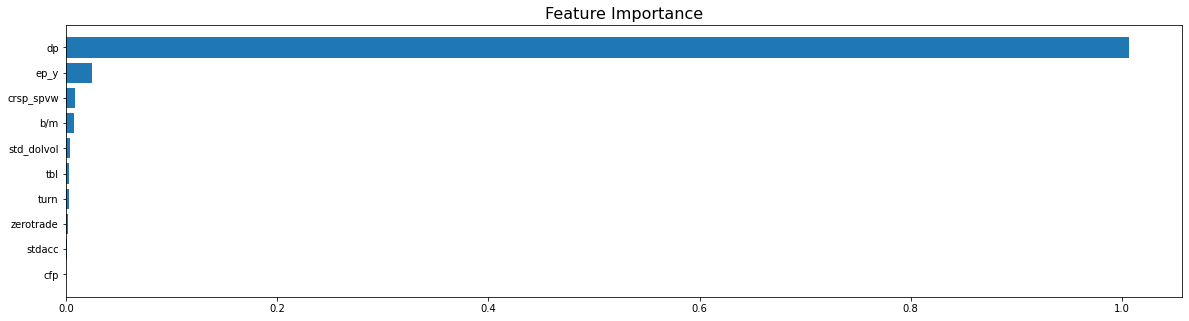

In [16]:
# Display chart
plt.figure(figsize=(20,5))
plt.barh(np.arange(len(df_10)),df_10.magnitude.values)
plt.yticks(np.arange(len(df_10)),df_10.index.values)
plt.title('Feature Importance',size=16)
plt.show()

We could not infer the exact meaning of dp. We have looked into the data specification in the annex of the paper and could not find any coinding with dp. We suspect that it could be dividend to price factor. <br><br>
The other most significant factors are e/p, b/m, crsp_spvw and st_dolvol. The first three factors are well-known macro factors. These results suggest that all most of the explainability of the model is dominated by macro factors.

### b.	Second, get a measure of the joint importance of all our “macro predictors” (i.e., those taken from Welch and Goyal 2008), by setting them all to zero and finding the decrease in out of sample R2. Comment on how important macroeconomic variables are relative to stock characteristics in predicting returns. 

In [21]:
X_train.columns[-11:]

Index(['dp', 'ep_y', 'b/m', 'crsp_spvw', 'svar', 'tbl', 'tms', 'dfy', 'dfr',
       'ntis', 'infl'],
      dtype='object')

In [22]:
feature_importance = {}
for column_name in tqdm(X_train.columns[-11:]):
    X_tmp = X_test.copy()
    X_tmp[column_name] = 0
    y_pred_temp = best_model.predict(X_tmp, batch_size=256).reshape(-1,1)
    feature_importance[column_name] = best_r_squared - r_squared(y_pred_temp, y_test)[0]

  0%|                                                    | 0/11 [00:00<?, ?it/s]

2922/2922 [==============================] - 2s 611us/step


  9%|████                                        | 1/11 [00:03<00:39,  3.93s/it]

2922/2922 [==============================] - 2s 614us/step


 18%|████████                                    | 2/11 [00:07<00:35,  3.93s/it]

2922/2922 [==============================] - 2s 601us/step


 27%|████████████                                | 3/11 [00:11<00:31,  3.90s/it]

2922/2922 [==============================] - 2s 603us/step


 36%|████████████████                            | 4/11 [00:15<00:27,  3.94s/it]

2922/2922 [==============================] - 2s 601us/step


 45%|████████████████████                        | 5/11 [00:19<00:23,  3.95s/it]

2922/2922 [==============================] - 2s 606us/step


 55%|████████████████████████                    | 6/11 [00:23<00:19,  3.98s/it]

2922/2922 [==============================] - 2s 598us/step


 64%|████████████████████████████                | 7/11 [00:27<00:15,  3.98s/it]

2922/2922 [==============================] - 2s 616us/step


 73%|████████████████████████████████            | 8/11 [00:31<00:11,  3.99s/it]

2922/2922 [==============================] - 2s 602us/step


 82%|████████████████████████████████████        | 9/11 [00:35<00:08,  4.04s/it]

2922/2922 [==============================] - 2s 623us/step


 91%|███████████████████████████████████████    | 10/11 [00:40<00:04,  4.12s/it]

2922/2922 [==============================] - 2s 621us/step


100%|███████████████████████████████████████████| 11/11 [00:44<00:00,  4.03s/it]


In [23]:
importance_df = pd.DataFrame.from_dict(feature_importance, orient='index', columns=['magnitude'])
importance_df = importance_df.sort_values(by=['magnitude'])

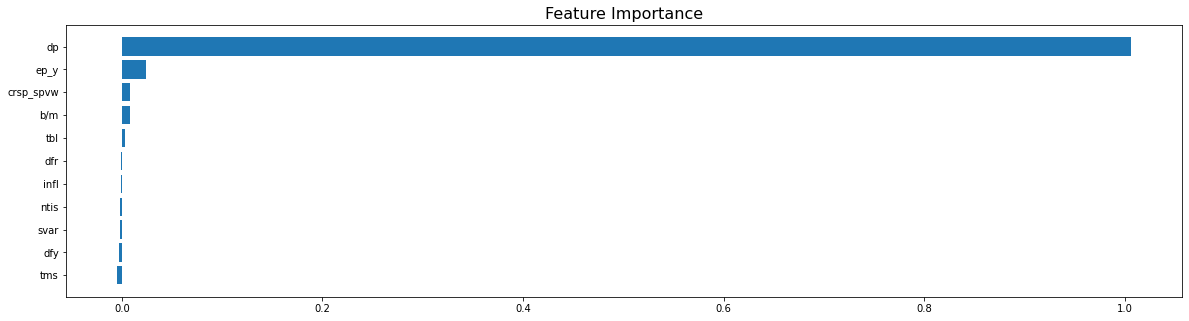

In [24]:
# Display chart
plt.figure(figsize=(20,5))
plt.barh(np.arange(len(importance_df)),importance_df.magnitude.values)
plt.yticks(np.arange(len(importance_df)),importance_df.index.values)
plt.title('Feature Importance',size=16)
plt.show()

As presented in (b), the macro factors seem to capture much of the explainability of our model. DP, e/p, crspvw and b/m seem to be the most significant. In fact, as previously shown, they dominate the top ten score on variable predictability of all the variables (stock + macro).

c.	Repeat the two steps above, but by using a measure of the sensitivity of predictions to each input variable, as outlined in the lectures.

**Due to the huge amount of variables, sensitivity analysis of only the top 10 most significant variables displayed in (a) will be carried out.**

In [25]:
results = []
print('Computing feature importance...')
for feature in tqdm(df_10.index.values):
    tmp = X_test.loc[:,feature].copy()
    median = X_test.median()
    X_temp = pd.DataFrame(index=X_test.index,columns=X_test.columns)
    X_temp.fillna(median,inplace=True)
    X_temp.loc[:,feature] = tmp
    y_preds = best_model.predict(X_temp.values,batch_size=256).reshape(-1,1) 
    results.append({'feature':tmp.values.reshape(1,-1)[0],'pred_return':y_preds.reshape(1,-1)[0]})  

Computing feature importance...


  0%|                                                    | 0/10 [00:00<?, ?it/s]

2922/2922 [==============================] - 2s 645us/step


 10%|████▍                                       | 1/10 [00:44<06:44, 44.94s/it]

2922/2922 [==============================] - 2s 589us/step


 20%|████████▊                                   | 2/10 [01:25<05:40, 42.55s/it]

2922/2922 [==============================] - 2s 729us/step


 30%|█████████████▏                              | 3/10 [02:08<04:58, 42.62s/it]

2922/2922 [==============================] - 2s 581us/step


 40%|█████████████████▌                          | 4/10 [02:50<04:13, 42.32s/it]

2922/2922 [==============================] - 2s 586us/step


 50%|██████████████████████                      | 5/10 [03:32<03:31, 42.30s/it]

2922/2922 [==============================] - 2s 797us/step


 60%|██████████████████████████▍                 | 6/10 [04:20<02:57, 44.31s/it]

2922/2922 [==============================] - 2s 601us/step


 70%|██████████████████████████████▊             | 7/10 [05:09<02:17, 45.84s/it]

2922/2922 [==============================] - 2s 617us/step


 80%|███████████████████████████████████▏        | 8/10 [05:57<01:32, 46.31s/it]

2922/2922 [==============================] - 2s 651us/step


 90%|███████████████████████████████████████▌    | 9/10 [06:44<00:46, 46.57s/it]

2922/2922 [==============================] - 2s 632us/step


100%|███████████████████████████████████████████| 10/10 [07:29<00:00, 44.97s/it]


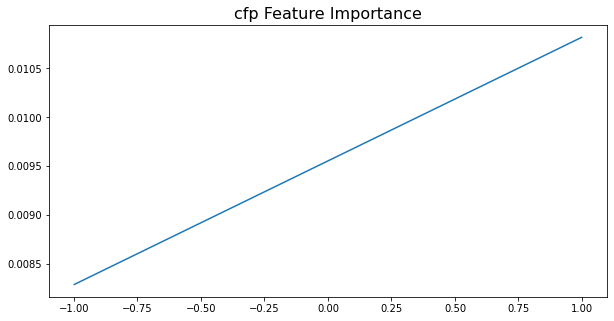

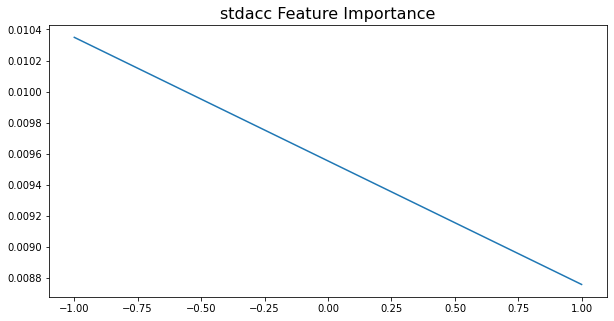

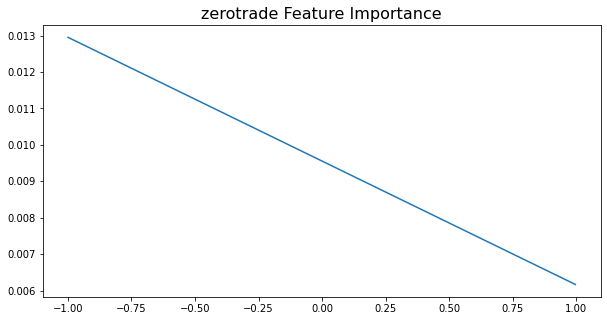

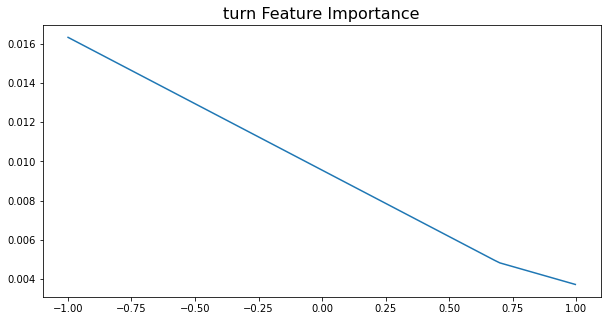

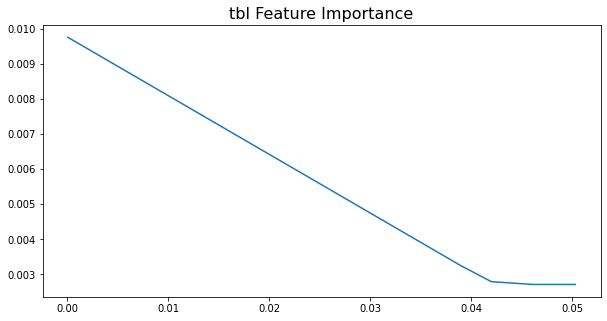

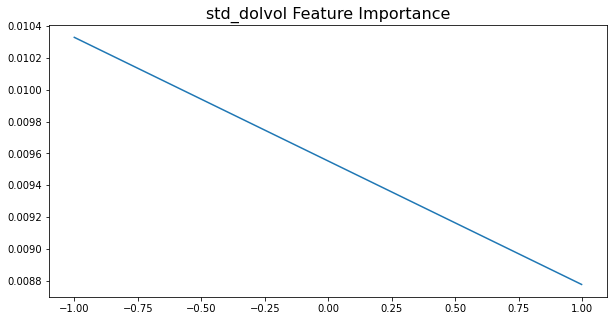

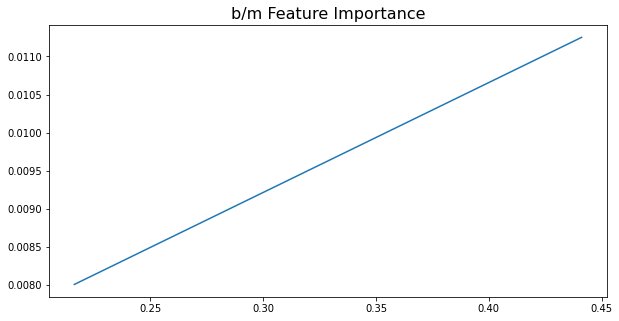

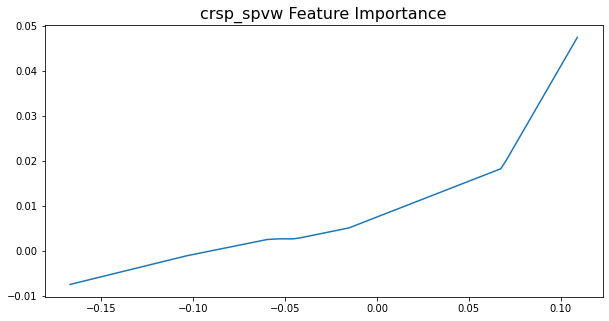

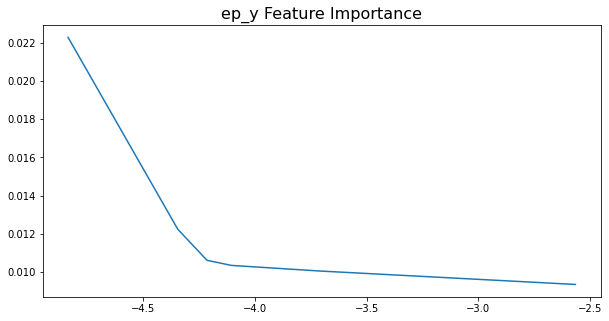

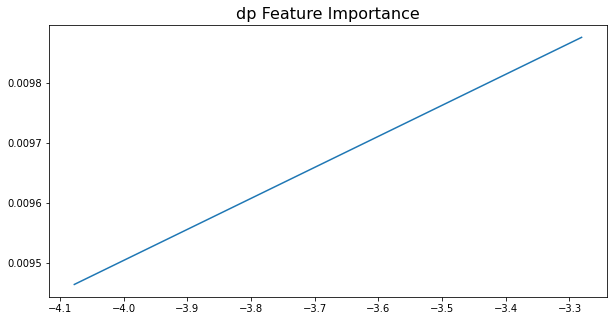

In [26]:
features = df_10.index.values
for i in range(len(results)):
    result = results[i]
    tmp_df = pd.DataFrame(result,index = np.arange(len(result['feature'])))
    tmp_df.sort_values(by=['feature'],inplace=True)
    plt.figure(figsize=(10,5))
    plt.title(f'{features[i]} Feature Importance',size=16)
    plt.plot(tmp_df.feature,tmp_df.pred_return)
    plt.show()

### 4.Fit a penalised linear model (LASSO) to the same data, using validation data to pick the best penalty (e.g., you can use the “sklearn” package in Python to do this easily). Compare its test data performance to the neural network. 

In [77]:
import seaborn as sns
from sklearn.metrics import r2_score, get_scorer
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import KFold, RepeatedKFold, GridSearchCV, cross_validate, train_test_split

In [78]:
#because lasso need too much memory, we have to reduce the size of train data
X_cv_reduced, x_tmp, y_cv_reduced, y_tmp = train_test_split(X,y,test_size=0.7,shuffle=True)

In [79]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
lasso = Lasso()
grid = {'alpha': np.linspace(0.1,2,4)}

gscv = GridSearchCV(lasso, grid, scoring='neg_mean_squared_error',cv=cv, verbose=10)
results = gscv.fit(X_cv_reduced.values, y_cv_reduced.values)
print('MSE: %.5f' % results.best_score_)
print('Config: %s' % results.best_params_)

Fitting 15 folds for each of 4 candidates, totalling 60 fits
[CV 1/15; 1/4] START alpha=0.1..................................................
[CV 1/15; 1/4] END ..................alpha=0.1;, score=-0.029 total time=   5.2s
[CV 2/15; 1/4] START alpha=0.1..................................................
[CV 2/15; 1/4] END ..................alpha=0.1;, score=-0.030 total time=   3.4s
[CV 3/15; 1/4] START alpha=0.1..................................................
[CV 3/15; 1/4] END ..................alpha=0.1;, score=-0.030 total time=   3.3s
[CV 4/15; 1/4] START alpha=0.1..................................................
[CV 4/15; 1/4] END ..................alpha=0.1;, score=-0.030 total time=   3.3s
[CV 5/15; 1/4] START alpha=0.1..................................................
[CV 5/15; 1/4] END ..................alpha=0.1;, score=-0.030 total time=   3.2s
[CV 6/15; 1/4] START alpha=0.1..................................................
[CV 6/15; 1/4] END ..................alpha=0.1;,

[CV 6/15; 4/4] END ..................alpha=2.0;, score=-0.030 total time=   3.3s
[CV 7/15; 4/4] START alpha=2.0..................................................
[CV 7/15; 4/4] END ..................alpha=2.0;, score=-0.031 total time=   3.3s
[CV 8/15; 4/4] START alpha=2.0..................................................
[CV 8/15; 4/4] END ..................alpha=2.0;, score=-0.029 total time=   3.3s
[CV 9/15; 4/4] START alpha=2.0..................................................
[CV 9/15; 4/4] END ..................alpha=2.0;, score=-0.029 total time=   3.4s
[CV 10/15; 4/4] START alpha=2.0.................................................
[CV 10/15; 4/4] END .................alpha=2.0;, score=-0.029 total time=   3.4s
[CV 11/15; 4/4] START alpha=2.0.................................................
[CV 11/15; 4/4] END .................alpha=2.0;, score=-0.028 total time=   3.3s
[CV 12/15; 4/4] START alpha=2.0.................................................
[CV 12/15; 4/4] END ........

In [80]:
best_model = gscv.best_estimator_
y_pred = best_model.predict(X_test.values).reshape(-1,1)
y_pred_top = best_model.predict(top_X_test).reshape(-1,1)
y_pred_bottom = best_model.predict(bottom_X_test).reshape(-1,1)
R2_oos_LASSO = pd.DataFrame(columns = ['R2_OOS','R2_OOS_top1000','R2_OOS_low1000'],index = ['LASSO'])
R2_oos_LASSO.iloc[0,0] = r_squared(y_pred,y_test.values)
R2_oos_LASSO.iloc[0,1] = r_squared(y_pred_top,top_y_test)
R2_oos_LASSO.iloc[0,2] = r_squared(y_pred_bottom,bottom_y_test)

In [81]:
R2_oos_LASSO*100

,R2_OOS,R2_OOS_top1000,R2_OOS_low1000
LASSO,0.128561,0.124777,0.508


Although the results show a reasonable performance compared to the null, the LASSO undeperform our best model NN4 in full, top-1000 and bottom-1000 sample. This suggest that the linear models, despite performing l1 penalization, fail to capture the nonlinear nature of our data. It would be interesting to evaluate NN4 against different non-linear alternatives. 

**5.Suppose somebody tells you to collect 10 more micro or macro variables that can predict returns and are not in our current dataset. How would you choose those variables, based on the intuitions you have gained in this project?**

When collecting 10 more micro or macro variables that are not already included in our
current dataset, we can start from the overall feature importance found in previous
question. For example, we find that the factors which have the highest feature importance
are macro factors. This suggests that when we search for new factors, it will be best to focus
on macro factors. We can do this by first sourcing a large number of macro variables to
which run a selection process on, the best method of this is to see for which variables we
have the best/cleanest readily-accessible data for when sourcing public data or data
provided by an institution. This will allow for more accurate performance results within the
data.<br><br>
It is important to consider variable importance and marginal relationships in all models
tested. Considering this allows us to gauge the relationship between our new variables and
the future returns. Our selection process can be the same as Gu, Kelly and Xiu, a multiple
staged process which aims to test importance, influence, marginal relationship and
robustness. We can also go through our own unique process; the important thing is to make
sure that we test for variable importance within each model and compare performance
using multiple measures.<br><br>
As a measure of performance within our selection process, we can use the same criteria
used by Gu, Kelly and Xiu (2019) and use a two-fold ranking system, measuring the
reduction of R^2 when setting the values of a single predictor to 0 and holding the rest
constant. Second, measure the sum of squared partial derivatives (SSD). Using two or more
performance measures allow us to measure performance of each predictor while allowing
to test the measures against one another to make sure they are in agreeance and
calculating correctly.<br><br>
We can make out marginal relations between returns and each characteristic, to help
visualise first-order impact of covariates. For each method, when we can calculate the
reduction in R^2 from setting all values of a given predictor to zero within each training
sample. Taking the average of these into a single importance measure for each predictor
will allow for more accurate results. Variable importance in each model is normalised to
sum to 1, which will allow for relative importance to be measured between the variables for
every model. This not only allows us to find the best 10 new variables that can predict
returns, but also allows us to measure their performance against our already existing
variables.<br><br>
If our new variables are of momentum and reversal categories then we would specially see
their influence on the linear models, due to being skewed towards these categories. Nonlinear
models such as, trees and neural networks, are less skewed and will show us a better
representation of these variables amongst the rest of the variables. If possible, testing using
both linear and non-linear models is important because each have their benefits and tell us
something unique about the data.<br><br>
It would be a good idea to use placebo characteristics independent of future returns, to test
for robustness of our models, these are dummy variables are generated to randomly and
should show no correlation with returns. The inclusion of these show that most influential
characteristics are unaffected by these noise variables, and that the placebo variables are
among the least important variables (rightly so). This will allow us to make sure that our
new variables are not influenced by other forces that do not have anything to do with
return.